In [1]:
import json
import pandas as pd
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
%cd drive/MyDrive/voter-behavior-prediction-LLM/

/content/drive/MyDrive/voter-behavior-prediction-LLM


In [4]:
# Constants
SAMPLE_SIZE = 90
RANDOM_STATE = 42

In [5]:
# Load the predictions from the JSON file
file_name = "results_gpt-3.5-turbo-0125_20240519153306.json"
with open(file_name, 'r', encoding='utf-8') as file:
    predictions = json.load(file)

In [6]:
# Function to determine the final prediction based on the majority vote from the prompts
def majority_vote(predictions):
    votes = [predictions['prompt1'], predictions['prompt2'], predictions['prompt3']]
    vote_count = {candidate: votes.count(candidate) for candidate in set(votes)}
    # Get the candidate with the most votes; in case of tie, it picks the first one it encounters
    final_prediction = max(vote_count, key=vote_count.get)
    return final_prediction

# Prepare the predictions DataFrame
predictions_df = pd.DataFrame([
    {'username': user, 'predicted_candidate': majority_vote(pred)}
    for user, pred in predictions.items()
])

In [7]:
# Load survey data
df_survey_data = pd.read_excel('survey.xlsx')
print("Survey data loaded successfully.")

Survey data loaded successfully.


In [8]:
# Normalize candidate names to a common format
def normalize_candidate_name(name):
    name = name.lower()
    if 'kılıçdaroğlu' in name:
        return 'kılıçdaroğlu'
    elif 'erdoğan' in name:
        return 'erdoğan'
    return name

# Ensure the 'username' in combined_samples is the correct column name to join on
merged_data = df_survey_data.merge(predictions_df, on='username', how='right')

# Normalize the candidate names in both true and predicted labels
merged_data['true_candidate'] = merged_data['CB 2. Tur'].apply(normalize_candidate_name)  # Adjust this to your actual true labels column name
merged_data['predicted_candidate'] = merged_data['predicted_candidate'].apply(normalize_candidate_name)

# Adjust this function to explicitly check for each candidate
def evaluate_prediction(row):
    true_cand = row['true_candidate']
    predicted_cand = row['predicted_candidate']

    if pd.notna(predicted_cand):
        if true_cand == predicted_cand:
            return 'TP'
        else:
            return 'FP'
    return 'FN'

merged_data['result'] = merged_data.apply(evaluate_prediction, axis=1)
tp = (merged_data['result'] == 'TP').sum()
fp = (merged_data['result'] == 'FP').sum()
fn = (merged_data['result'] == 'FN').sum()

# Calculate precision, recall, and F1 score
precision = tp / (tp + fp) if tp + fp > 0 else 0
recall = tp / (tp + fn) if tp + fn > 0 else 0
f1 = 2 * (precision * recall) / (precision + recall) if precision + recall > 0 else 0

print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

Precision: 0.6961325966850829
Recall: 1.0
F1 Score: 0.8208469055374593


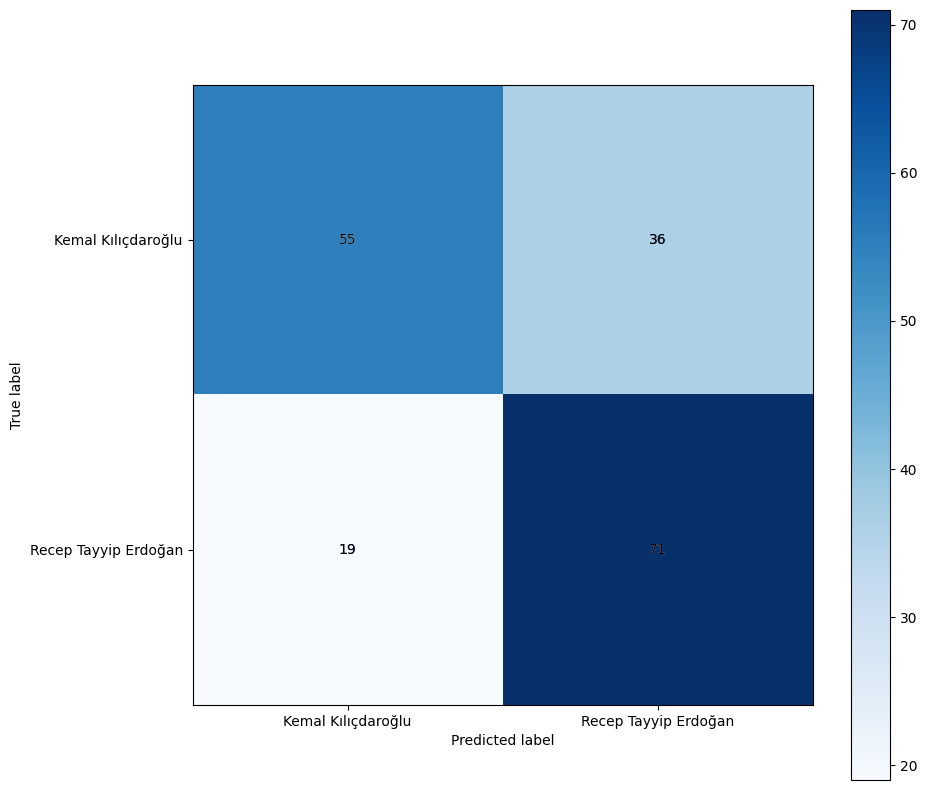

In [9]:
# Generate the confusion matrix
true_labels = merged_data['true_candidate']
predicted_labels = merged_data['predicted_candidate']

# Compute confusion matrix
cm = confusion_matrix(true_labels, predicted_labels, labels=['kılıçdaroğlu', 'erdoğan'])

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Kemal Kılıçdaroğlu', 'Recep Tayyip Erdoğan'])

fig, ax = plt.subplots(figsize=(10, 10))
disp.plot(cmap=plt.cm.Blues, ax=ax)

# Annotate the confusion matrix with counts, but only where the count is greater than zero
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        if cm[i, j] > 0:
            plt.text(j, i, f'{cm[i, j]}', ha='center', va='center', color='black')

plt.show()